In [1]:
!pip install faker
!pip install tqdm
!pip install keras_preprocessing
!pip install keras

     |████████████████████████████████| 1.0MB 2.8MB/s 


In [2]:
import sys
import requests
import tarfile
import json
import numpy as np
from os import path
from PIL import Image
from PIL import ImageFont, ImageDraw
from glob import glob
from matplotlib import pyplot as plt
import cv2

import random
from tqdm import tqdm

from faker import Faker
import re
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import CSVLogger

from keras.applications import MobileNetV2

from keras.layers import *
from keras.models import Model

Using TensorFlow backend.


In [3]:
#Variablen
img_w = 512
img_h = 512
channels = 3
classes = 1
info = 5
grid_w = 16
grid_h = 16

# Funktionen

## Laden der Boxes


In [4]:
# Function to viz the annotation

target = 512

def markup(BildWeg, annotations):
  # laden der Zusatdaten
  Bild = cv2.imread(BildWeg)
  x_ = Bild.shape[1]
  y_ = Bild.shape[0]

  x_scale = target/x_
  y_scale = target/y_

  Bild = cv2.resize(Bild, (target, target))

  # laden der Infos
  Y = np.zeros((grid_h,grid_w,1,5))
  i, j = 0, 0
  for annotation in annotations:
    # "bbox": [37.59, 433.64, 251.07, 20.38]

    Left, Top, Right, Bottom = annotation['bbox'][0], annotation['bbox'][1], annotation['bbox'][2], annotation['bbox'][3]

    Left = int(np.round(Left * x_scale))
    Top = int(np.round(Top * y_scale))
    Rigth = int(np.round(Right * x_scale))
    Bottom = int(np.round(Bottom * y_scale))

    Y[i ,j , 0, 0] = 1
    Y[i ,j , 0, 1] = Left
    Y[i ,j , 0, 2] = Top
    Y[i ,j , 0, 3] = Rigth
    Y[i ,j , 0, 4] = Bottom
    
    i+= 1 
    if (i == grid_h):
      j += 1
      i = 0

  return Bild, Y

In [5]:
def load(test):
  Train = []
  Lösung = []
  for i, (_, image) in enumerate(test.items()):
      TempImage, ZielMuster = markup(image['file_name'], image['annotations'])
      Train.append(TempImage)
      Lösung.append(ZielMuster)

  Train = np.array(Train)
  Lösung = np.array(Lösung)
  return Train, Lösung

## Decoden von dem was die KI sagt

In [41]:

import numpy as np
import os
import tensorflow as tf
from scipy.io import loadmat
import cv2
import matplotlib.pyplot as plt

def decode(output):
  #output : (x,x,1,5)
  #x,y,h,w

  threshold = 0.2

  boxes = []
  #print(output.shape)

  for i in range(grid_h-1):
    for j in range(grid_w-1):
      try:
        temp = output[i,j,0]
        temp = temp[0]
        if(temp[0]>threshold):
          #print(temp[1:5])
          temp = temp[1:5]
          
          Left = temp[0]
          Top = temp[1]
          Rigth = temp[0] + temp[2]
          Bottom = temp[1] + temp[3]
          
          box = [Left, Top, Rigth, Bottom]
          box = np.array(box)
          boxes.append(box)
      except Exception:
        pass

  return np.array(boxes)

## Model Funktionen


In [7]:
def yolo_model(input_shape):
    
    inp = Input(input_shape)
   
    model = MobileNetV2( input_tensor= inp , include_top=False, weights='imagenet')
    last_layer = model.output
    
    conv = Conv2D(512,(3,3) , activation='relu' , padding='same', name="ErstesCNNLayer")(last_layer)
    conv = Dropout(0.4)(conv)
    bn = BatchNormalization()(conv)
    lr = LeakyReLU(alpha=0.1)(bn)
    
    
    conv = Conv2D(128,(3,3) , activation='relu' , padding='same', name="ZweitesCNNLayer")(lr)
    conv = Dropout(0.4)(conv)
    bn = BatchNormalization()(conv)
    lr = LeakyReLU(alpha=0.1)(bn)
    
    
    conv = Conv2D(5,(3,3) , activation='relu' , padding='same')(lr)
    
    final = Reshape((grid_h,grid_w,classes,info), name="Finale")(conv)
    
    model = Model(inp,final)
    
    return model

In [8]:
def yolo_loss_func(y_true,y_pred):
    # y_true : 16,16,1,5
    # y_pred : 16,16,1,5
    l_coords = 5.0
    l_noob = 0.5
    coords = y_true[:,:,:,:,0] * l_coords
    noobs = (-1*(y_true[:,:,:,:,0] - 1)*l_noob)
    p_pred = y_pred[:,:,:,:,0]
    p_true = y_true[:,:,:,:,0]
    x_true = y_true[:,:,:,:,1]
    x_pred = y_pred[:,:,:,:,1]
    yy_true = y_true[:,:,:,:,2]
    yy_pred = y_pred[:,:,:,:,2]
    w_true = y_true[:,:,:,:,3]
    w_pred = y_pred[:,:,:,:,3]
    h_true = y_true[:,:,:,:,4]
    h_pred = y_pred[:,:,:,:,4]
    
    p_loss_absent = K.sum(K.square(p_pred - p_true)*noobs)
    p_loss_present = K.sum(K.square(p_pred - p_true))
    x_loss = K.sum(K.square(x_pred - x_true)*coords)
    yy_loss = K.sum(K.square(yy_pred - yy_true)*coords)
    xy_loss = x_loss + yy_loss
    w_loss = K.sum(K.square(K.sqrt(w_pred) - K.sqrt(w_true))*coords)
    h_loss = K.sum(K.square(K.sqrt(h_pred) - K.sqrt(h_true))*coords)
    wh_loss = w_loss + h_loss
    
    loss = p_loss_absent + p_loss_present + xy_loss + wh_loss
    
    return loss

# Model Bau

In [9]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

#optimizer
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

csv_logger = CSVLogger('log.csv', append=True, separator=';')

#checkpoint
checkpoint = ModelCheckpoint('model1/text_detect.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min',period=1)

In [10]:
model = yolo_model((512,512,3))

model.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 2s 0us/step


# Training


In [11]:
def openTar(Name):
  tar = tarfile.open(Name)
  tar.extractall()
  tar.close()
  print(Name + " entpacked")


In [12]:
x = []
y = []

In [13]:
#Daten Laden


!curl https://dax-cdn.cdn.appdomain.cloud/dax-publaynet/1.0.0/val.tar.gz --output "val.tar.gz"
openTar("val.tar.gz")
!rm val.tar.gz

#!curl https://dax-cdn.cdn.appdomain.cloud/dax-publaynet/1.0.0/train-1.tar.gz --output "train-1.tar.gz"
#openTar("train-1.tar.gz")
#!rm train-1.tar.gz

#!curl https://dax-cdn.cdn.appdomain.cloud/dax-publaynet/1.0.0/train-0.tar.gz --output "train-0.tar.gz"
#openTar("train-0.tar.gz")
#!rm train-0.tar.gz

#!curl https://dax-cdn.cdn.appdomain.cloud/dax-publaynet/1.0.0/train-2.tar.gz --output "train-2.tar.gz"
#openTar("train-2.tar.gz")
#!rm train-2.tar.gz

!curl https://dax-cdn.cdn.appdomain.cloud/dax-publaynet/1.0.0/labels.tar.gz --output "labels.tar.gz"
openTar("labels.tar.gz")
!rm labels.tar.gz


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3106M  100 3106M    0     0  60.2M      0  0:00:51  0:00:51 --:--:-- 38.9M
val.tar.gz entpacked
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  313M  100  313M    0     0  64.8M      0  0:00:04  0:00:04 --:--:-- 72.5M
labels.tar.gz entpacked


In [18]:
StringToJson = 'publaynet/val.json'
StringToFolder = 'publaynet/val/'

NumberPerTirm = 1000

# 335,703 Bilder

In [19]:
testArray = []

with open(StringToJson, 'r') as fp:
    samples = json.load(fp)
# Index images
images = {}
for image in samples['images']:
    testArray.append(image['id'])
    images[image['id']] = {'file_name': StringToFolder + image['file_name'], 'annotations': []}
for ann in samples['annotations']:
    images[ann['image_id']]['annotations'].append(ann)

In [20]:
# model = keras.models.load_model('model1000')

In [21]:
max_Loss_Pos =  1000000
max_Loss_Neg = -1000000

for p in range(0,335703,NumberPerTirm):
  print("\n\nStarte bei Bild --------------- " + str(p))

  test = {}
  for _ in range(NumberPerTirm):
    try:
      id = testArray.pop(0)
      test[id] = images[id]
    except Exception:
      break
    

  x,y = load(test)

  hist = model.fit(x, y, epochs= 5 ,batch_size = 4, validation_split=0.2, callbacks=[csv_logger])
  
  loss = hist.history['loss'][4]

  if (loss < 0 and loss > max_Loss_Neg):
    model.save('model' + str(p))
    max_Loss_Neg = loss
  if (loss > 0 and loss < max_Loss_Pos):
    model.save('model' + str(p))
    max_Loss_Poss = loss

 
  



Starte bei Bild --------------- 0
Train on 800 samples, validate on 200 samples
Epoch 1/5
800/800 [==============================] - 134s 167ms/step - loss: -76.2798 - accuracy: 0.8766 - val_loss: -66.1446 - val_accuracy: 0.9046
Epoch 2/5
800/800 [==============================] - 112s 139ms/step - loss: -79.2176 - accuracy: 0.9101 - val_loss: -71.8580 - val_accuracy: 0.9350
Epoch 3/5
800/800 [==============================] - 111s 139ms/step - loss: -79.1088 - accuracy: 0.9130 - val_loss: -72.0247 - val_accuracy: 0.9063
Epoch 4/5
800/800 [==============================] - 112s 140ms/step - loss: -78.8093 - accuracy: 0.9117 - val_loss: -68.3442 - val_accuracy: 0.6570
Epoch 5/5
800/800 [==============================] - 111s 139ms/step - loss: -79.0950 - accuracy: 0.9144 - val_loss: -70.9406 - val_accuracy: 0.8827


Starte bei Bild --------------- 1000
Train on 800 samples, validate on 200 samples
Epoch 1/5
800/800 [==============================] - 112s 139ms/step - loss: -77.4919 - 

ValueError: ignored

# Auswertung


In [23]:
plt.xkcd()

In [24]:
import csv

Model_epoch = []
accuracy = []
loss = []
val_accurecy = []
val_loss = []

with open('log.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=';')
    header = next(spamreader)
    for row in spamreader:
         Wert = row[0]
         Model_epoch.append(float(Wert))
         Wert = row[1]
         accuracy.append(float(Wert))
         Wert = row[2]
         loss.append(float(Wert))
         Wert = row[3]
         val_accurecy.append(float(Wert))
         Wert = row[4]
         val_loss.append(float(Wert))

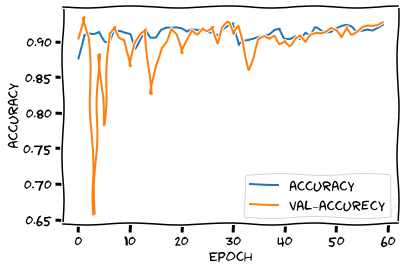

In [43]:
plt.plot(accuracy, label = 'accuracy')
plt.plot(val_accurecy, label = 'val_accurecy')

plt.xlabel('Epoch')
plt.ylabel('accuracy')
#plt.ylim([0.8, 1])
plt.legend(loc='lower right')
plt.show()

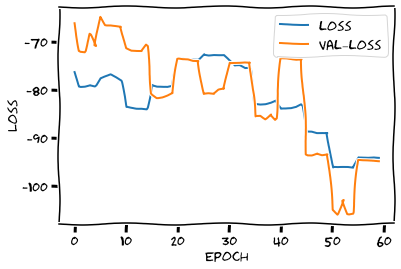

In [36]:
plt.plot(loss, label = 'loss')
plt.plot(val_loss, label = 'val_loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim([0, 1])
plt.legend(loc='upper right')
plt.show()

# Analyse

In [27]:
# Daten Laden
!curl https://dax-cdn.cdn.appdomain.cloud/dax-publaynet/1.0.0/examples.tar.gz --output "examples.tar.gz"
openTar("examples.tar.gz")
!rm examples.tar.gz

StringToJSON = 'examples/samples.json'
StringToFolder = 'examples/'

testArray = []

with open(StringToJSON, 'r') as fp:
    samples = json.load(fp)
# Index images
images = {}
for image in samples['images']:
    testArray.append(image['id'])
    images[image['id']] = {'file_name': StringToFolder + image['file_name'], 'annotations': []}
for ann in samples['annotations']:
    images[ann['image_id']]['annotations'].append(ann)

x,y = load(images)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6309k  100 6309k    0     0  17.0M      0 --:--:-- --:--:-- --:--:-- 17.0M
examples.tar.gz entpacked


In [28]:
print(x.shape)
print(y.shape)

(20, 512, 512, 3)
(20, 16, 16, 1, 5)


In [29]:
model = keras.models.load_model('model5000')

In [39]:
import os
from matplotlib.pyplot import figure

def predict_func(model , inp , iou , name, test):

    figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')

    ans = model.predict(inp)
    #ans = test
    
    boxes = decode(ans)
    true_boxes = decode(test)

    img = ((inp + 1)/2)
    img = img[0]

    #plt.imshow(img)
    #plt.show()

    print("Das Netz erkennt: " + str(len(boxes)) + " und sollte " + str(len(true_boxes)) + " erkennen")


    for i in boxes:

        i = [int(x) for x in i]
        img = cv2.rectangle(img , (i[0] ,i[1]) , (i[2] , i[3]) , color = (0,255,0) , thickness = 3)

    plt.imshow(img)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Das Netz erkennt: 2 und sollte 10 erkennen


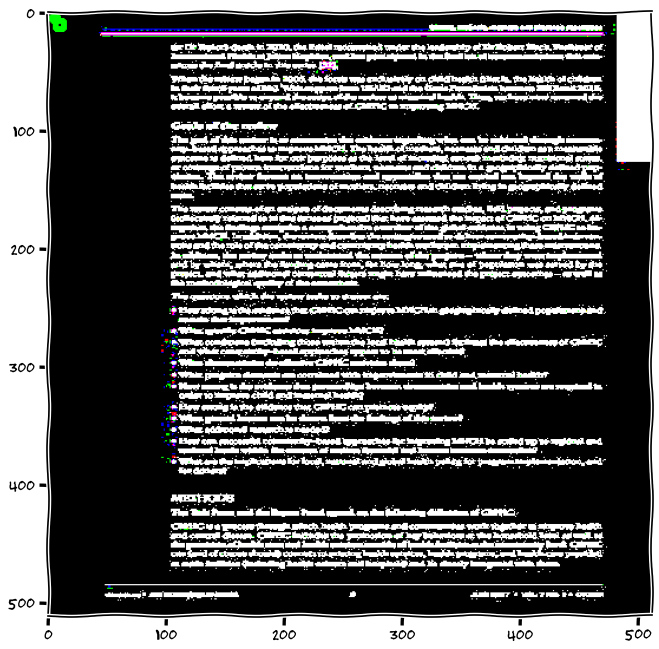

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Das Netz erkennt: 4 und sollte 7 erkennen


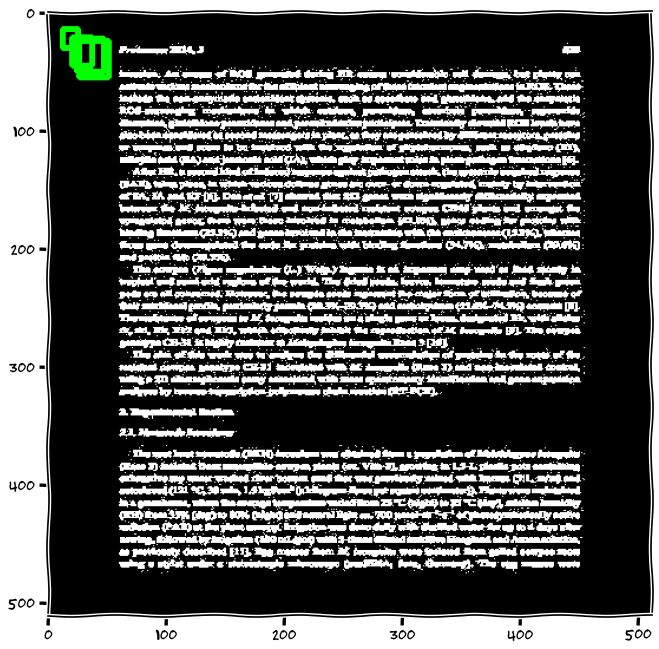

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Das Netz erkennt: 10 und sollte 6 erkennen


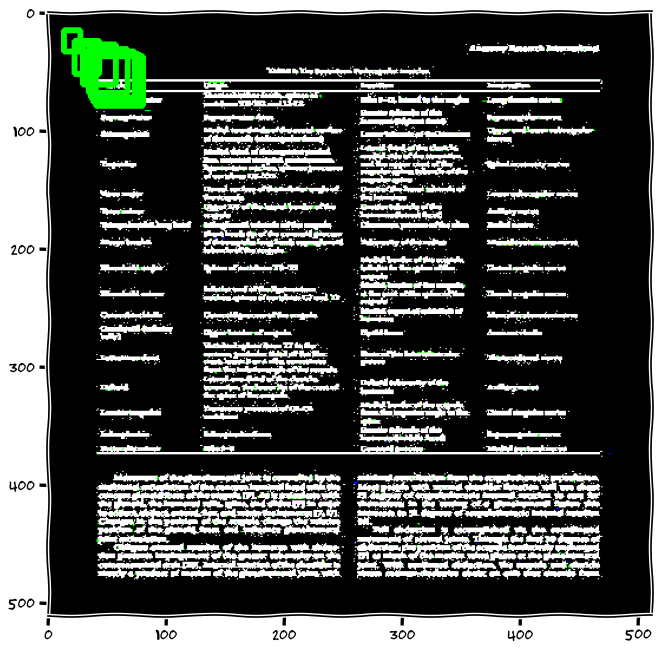

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Das Netz erkennt: 7 und sollte 15 erkennen


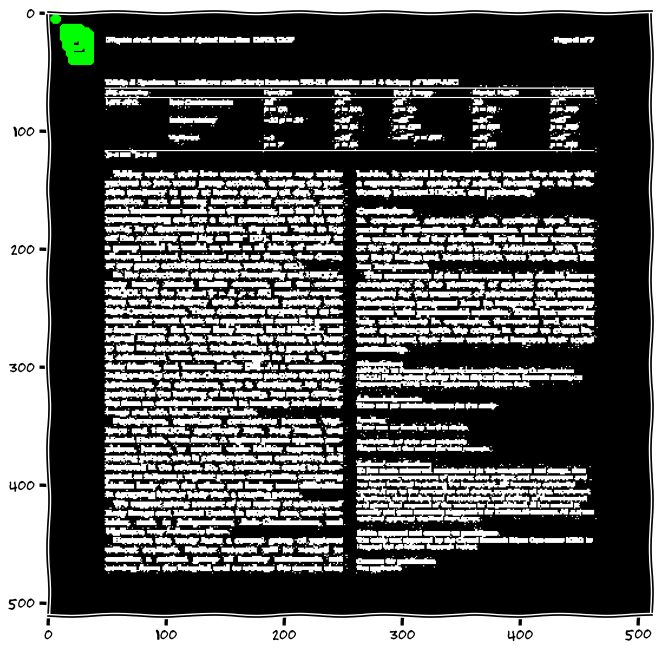

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Das Netz erkennt: 5 und sollte 8 erkennen


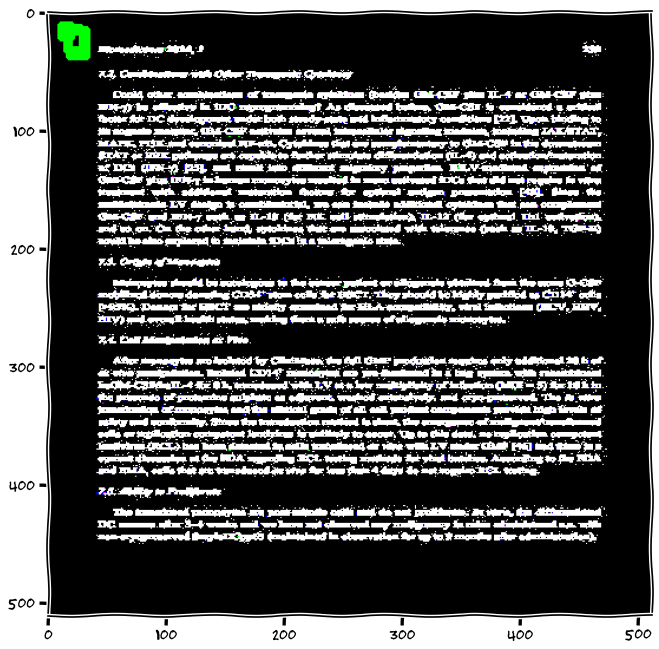

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Das Netz erkennt: 7 und sollte 5 erkennen


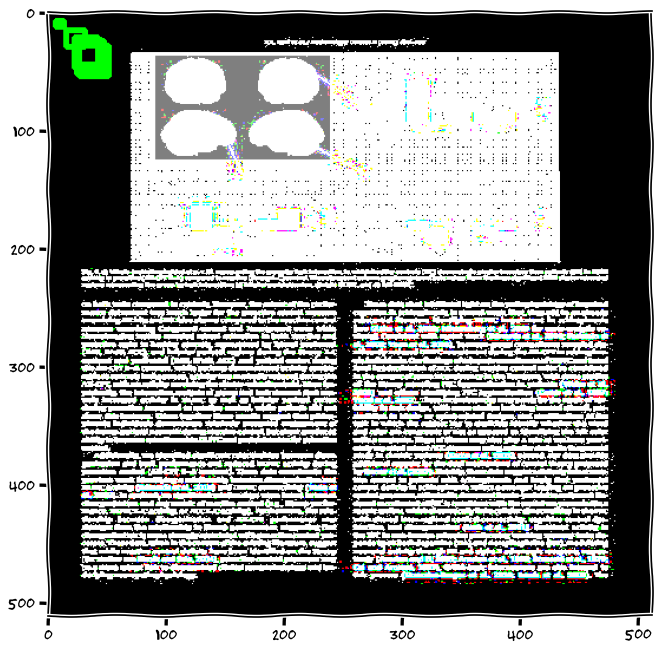

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Das Netz erkennt: 10 und sollte 12 erkennen


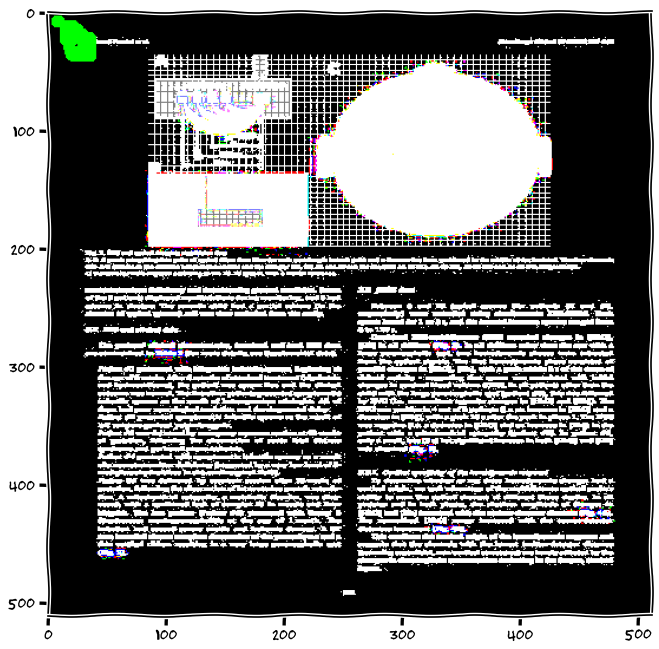

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Das Netz erkennt: 6 und sollte 8 erkennen


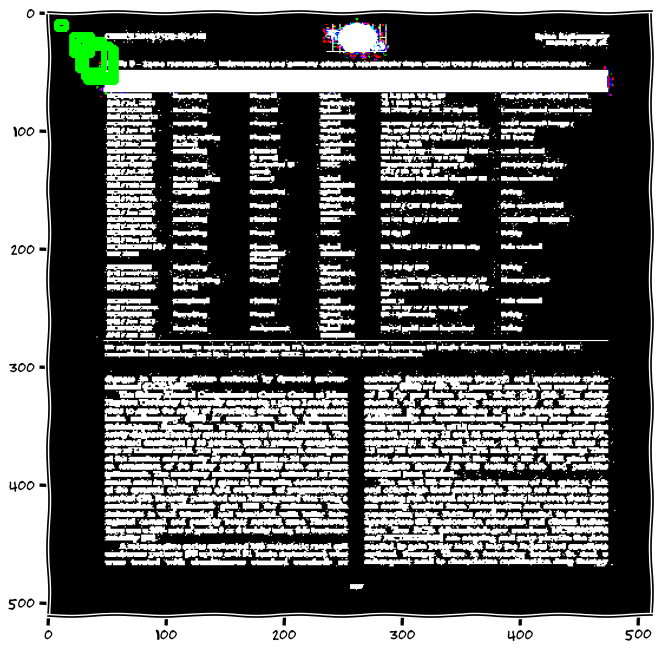

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Das Netz erkennt: 5 und sollte 8 erkennen


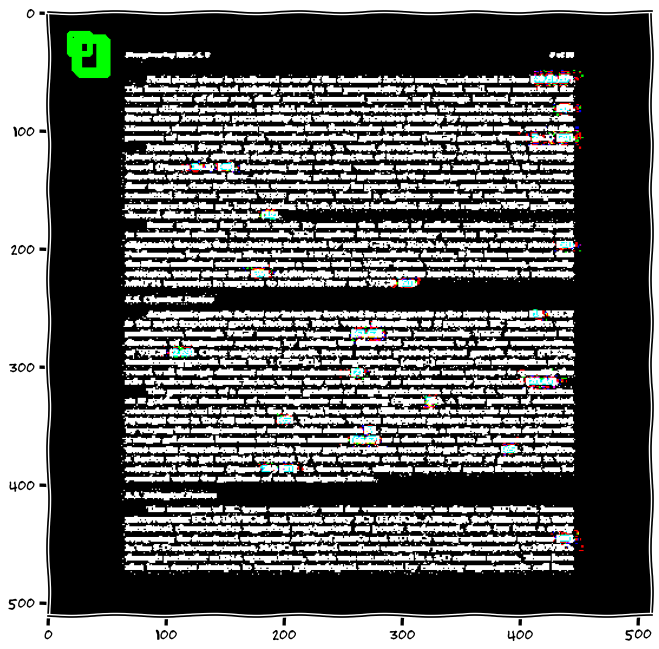

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Das Netz erkennt: 6 und sollte 2 erkennen


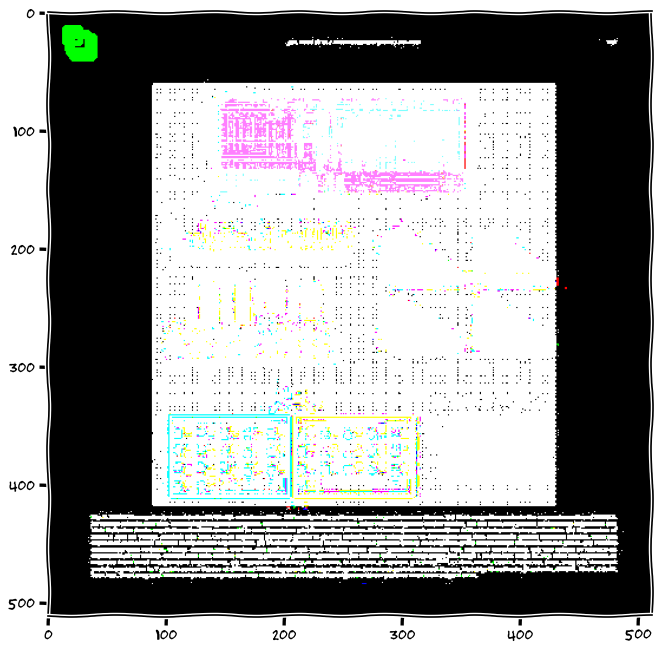

In [42]:
for i in range(10):
  temp = x[i:i+1]
  test = y[i:i+1]
  predict_func(model, temp, 0.5, str(i), test)